In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import time
from datetime import datetime
import pymysql
from real_stock_price_scraper import get_stock_price
%matplotlib inline

In [51]:
#mysql server credentials
host_name = "localhost" 
username = "root"
password = "root"
database_name = "stock_price"  


db = pymysql.connect(
    host=host_name,  # DATABASE_HOST
    port=3306,
    user=username,  # DATABASE_USERNAME
    passwd=password,  # DATABASE_PASSWORD
    db=database_name,  # DATABASE_NAME
    charset='utf8'
)

In [62]:
item_list = ['삼성전자','신풍제약','SK']

#default df(first item) for merging all data
SQL = "SELECT date,close as {table} FROM {table}_{date}".format(table=item_list[0],date=datetime.strftime(datetime.today(), '%Y%m%d'))
df = pd.read_sql(SQL,db)

#from second item
for item in item_list[1:]:
    SQL = "SELECT date,close as {table} FROM {table}_{date}".format(table=item, date='20200918')
    add_df = pd.read_sql(SQL,db)
    df = df.merge(add_df, on='date')    
df.columns = ['date','samsung elec','shinpung','sk']
item_list = ['samsung elec','shinpung','sk']

In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
samsung elec,426.0,49795.070423,5552.810554,37450.0,45362.5,48950.0,54200.0,62400.0
shinpung,426.0,21105.446009,33226.751319,5020.0,6780.0,7515.0,18737.5,196000.0
sk,426.0,234462.441315,34240.169016,107000.0,213125.0,239000.0,260500.0,318000.0


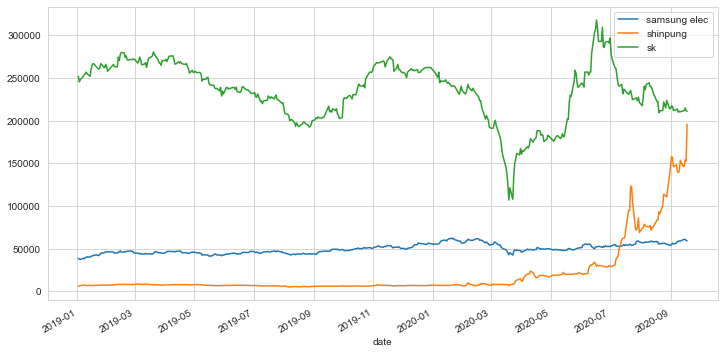

In [64]:
df.dropna().set_index('date').plot(legend=True, figsize=(12,6))

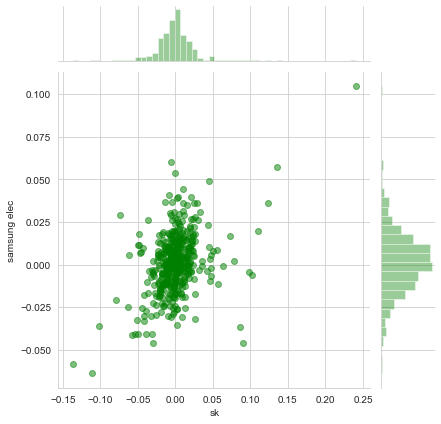

In [65]:
#correlation between two assets: SK and Samsung Electronics (vert weak correlation)
sns.set_style("whitegrid")
sns.jointplot(df['sk'].pct_change(),df['samsung elec'].pct_change(),kind='scatter',color='green', alpha=0.5)

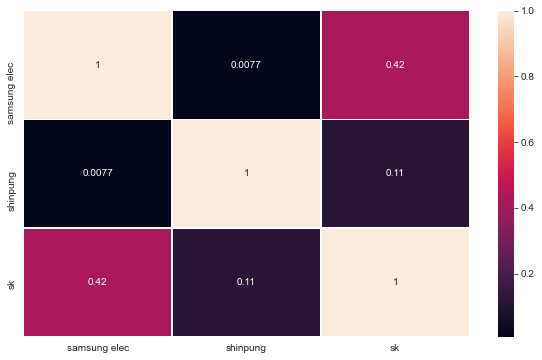

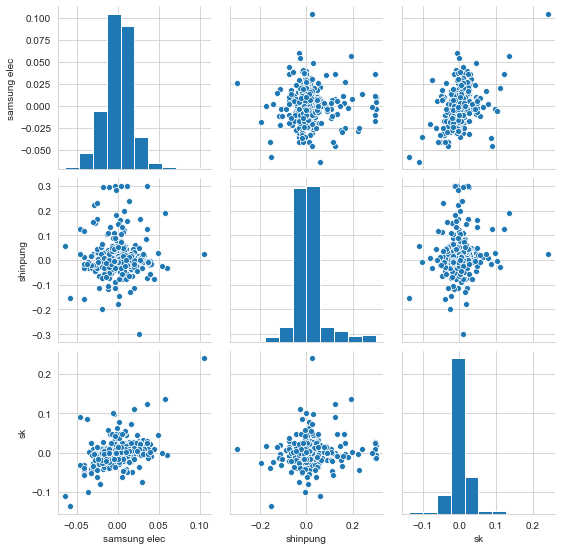

In [66]:
#correlations 
#: not strong but somewhat correlated between IT assets
pct_change_df = df.set_index('date').pct_change()
df_corr= pct_change_df.dropna().corr()

fig, ax = plt.subplots(figsize=(10,6))         
sns.heatmap(df_corr, annot=True, linewidths=.5, ax=ax)
sns.pairplot(pct_change_df.dropna())
plt.show()

In [67]:
df = df.set_index('date').dropna()

## (1) Individual Asset's Annual Return and Volatility

In [70]:
for stock in item_list:
    returns = df[stock].pct_change()
    mean_return = returns.mean()
    return_stdev = returns.std()
    annual_return = round(mean_return * 252,2)
    annual_stdev = round(return_stdev * np.sqrt(252),2)
    print(stock)
    print ('-Annual mean return:', annual_return)
    print('-Annual volatility:', annual_stdev)

samsung elec
-Annual mean return: 0.29
-Annual volatility: 0.29
shinpung
-Annual mean return: 2.58
-Annual volatility: 1.06
sk
-Annual mean return: -0.0
-Annual volatility: 0.46


## (2) Portfolio's Annual Return and Volatility

In [72]:
#daily returns
rets = df.pct_change()

#mean and covariance
mean_daily_rets = rets.mean()
cov_matrix = rets.cov()

#weights - 10% each
weights = np.array([0.2,0.2,0.4]) 

#annual portfolio return and volatility
prf_rets = np.sum(mean_daily_rets*weights*252)
prf_std = np.sqrt(weights.T@(cov_matrix@weights))*np.sqrt(252)

print('Portfolio expected annualized return: {:.2f} and volatility is {:.2f}'.format(prf_rets,prf_std))

Portfolio expected annualized return: 0.57 and volatility is 0.32


## (3) Optimal Annual Return and Volatility using Monte-Carlo simulation

In [76]:
num_sim = 10000
results = np.zeros((3+len(item_list),num_sim))

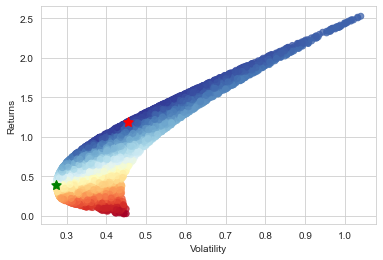

In [79]:
for i in range(num_sim):
    weights = np.random.random(3)
    weights = weights/sum(weights)
    
    prf_rets = np.sum(mean_daily_rets*weights*252)
    prf_std = np.sqrt(weights.T@(cov_matrix@weights))*np.sqrt(252)
    
    results[0,i] = prf_rets
    results[1,i] = prf_std
    results[2,i] = results[0,i]/results[1,i]  #did not include Sharpe ratio for the simplicity
    
    for j in range(len(weights)):
        results[j+3,i] = weights[j]
resultsDF = pd.DataFrame(results.T, columns=['returns','stdev','sharpe', 
                                             item_list[0], item_list[1], item_list[2]])

#locate position of portfolio with highest Sharpe Ratio
max_sharpe = resultsDF.iloc[resultsDF['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol = resultsDF.iloc[resultsDF['stdev'].idxmin()]

plt.scatter(resultsDF.stdev, resultsDF.returns, c=resultsDF.sharpe, cmap='RdYlBu', alpha=0.75)
plt.xlabel('Volatility')
plt.ylabel('Returns')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=100)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol[1],min_vol[0],marker=(5,1,0),color='g',s=100)
plt.savefig('res.png')

In [80]:
print(pd.DataFrame(max_sharpe.rename('max_sharpe')))

              max_sharpe
returns         1.191613
stdev           0.453481
sharpe          2.627701
samsung elec    0.602759
shinpung        0.393347
sk              0.003895


In [81]:
print(pd.DataFrame(min_vol.rename('min_volatility')))

              min_volatility
returns             0.392080
stdev               0.274657
sharpe              1.427530
samsung elec        0.822636
shinpung            0.058062
sk                  0.119302
